# Q1) Exploring the LJ Potential and Cutoffs

In [2]:
import math
import matplotlib.pyplot as plt

# special jupyter notebook command to make plots interactive
%matplotlib notebook

In [3]:
def calculate_LJ(r_ij):
    r6_term = math.pow(1/r_ij, 6)
    r12_term = math.pow(1/r_ij, 12)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy

<IPython.core.display.Javascript object>


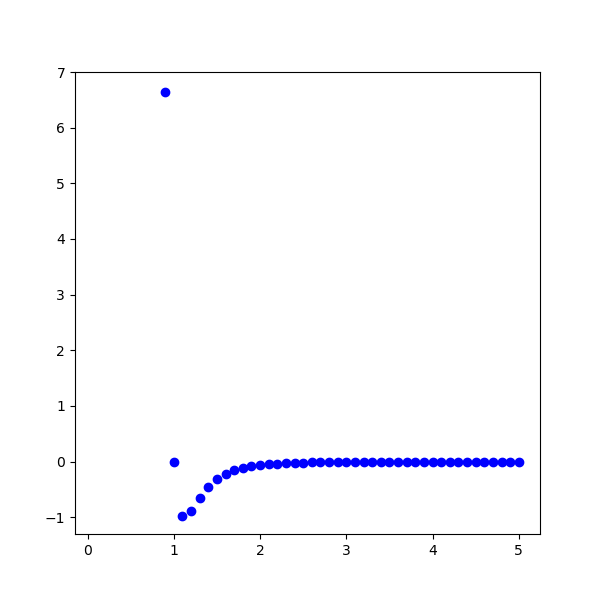

(-1.3, 7.0)

In [4]:
#creating figure
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.set_ylim([-1.3, 7])

In [5]:
for i in range(1, 51):
    r = i*0.1
    y = calculate_LJ(r)
    ax.plot(r,y,'ob')
    

## I agree with the cut-off choice of $3\sigma$, because in the graph above the energy plateaus from $3\sigma$ onwards and so calculating those values would be a waste of computational power.

In [6]:
def calculate_distance(coord1, coord2):
    """
    Calculate the distance between two 3D coordinates.
   
    Parameters
    ----------
    coord1, coord2: list
        The atomic coordinates
    
    Returns
    -------
    distance: float
        The distance between the two points.
    """
    distance = 0
        
    
    for i in range(3):
        distance += math.pow(coord2[i] - coord1[i], 2)
    
    
    return math.sqrt(distance)


In [54]:
## Counting Calculate total energy function here without cutoffs
def calculate_total_energy_nocutoff(coordinates):
    count = 0
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = calculate_distance(coordinates[i], coordinates[j])
            pairwise_energy = calculate_LJ(dist_ij)
            count += 1
            
            total_energy += pairwise_energy
    
    return total_energy, count

In [55]:
## Counting Calculate total energy function here to account for cutoffs
def calculate_total_pair_energy(coordinates, cutoff):
    count = 0
    total_energy = 0
    num_atoms = len(coordinates)

    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            # Calculate the distance between the particles - exercise.
            dist_ij = calculate_distance(coordinates[i], coordinates[j])

            if dist_ij < cutoff:
                # Calculate the pairwise LJ energy
                LJ_ij = calculate_LJ(dist_ij)
                count += 1

                # Add to total energy.
                total_energy += LJ_ij
    return total_energy, count

In [56]:
# Provided function

def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length


In [57]:
## Read in first sample configuration file here
import os
config1_file = os.path.join("../../lj_sample_configurations", "lj_sample_config_periodic1.txt")

sample_coords, box_length = read_xyz(config1_file)

print(box_length)
print(len (sample_coords))
print(calculate_total_energy_nocutoff(sample_coords))
print(calculate_total_pair_energy(sample_coords, 3))
print(calculate_total_pair_energy(sample_coords, 4))


10.0
800
(-3582.239311831134, 319600)
(-3487.4542328619536, 24838)
(-3552.7172669906026, 52102)


## For sample config file 1, without using cut-offs we run 319600 pairwise calculations, using a cutoff of $3\sigma$ we run about 24838, and using a cutoff of $4\sigma$ we run about 52102. Thus we save 294,762 , and 267, 498 calculations for cutoffs $3\sigma$ and $4\sigma$, respectively.

In [62]:
## Calculate total energy function here with a cutoff variable.
def calculate_total_energy(coordinates, cutoff):
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = calculate_distance(coordinates[i], coordinates[j])
            if dist_ij < cutoff:
                pairwise_energy = calculate_LJ(dist_ij)
                total_energy += pairwise_energy
    
    return total_energy

# Q2) Tail Correction

In [67]:
def calculate_tail_correction(num_particles, box_length, cutoff):
    """
    The tail correction associated with using a cutoff radius.
    
    Computes the tail correction based on a cutoff radius used in the LJ energy calculation in reduced units.
    
    Parameters
    ----------
    num_particles : int
        The number of particles in the system.
    
    box_length : int
        Size of the box length of the system, used to calculate volume.
    
    cutoff : int
        Cutoff distance.
    
    Returns
    -------
    tail_correction : float
        The tail correction associated with using the cutoff.
    """
    
    brackets = (1/3*math.pow(1/cutoff,9)) - math.pow(1/cutoff,3)
    volume = box_length**3
    
    constant = ((8*math.pi*(num_particles**2))/(3*volume))
    
    tail_correction = constant * brackets
    
    return tail_correction
    

In [68]:
assert round(calculate_tail_correction(800, 10, 3), 2) == -198.49
assert round(calculate_tail_correction(800, 10, 4), 3) == -83.769

## The value outputed by calculate_tail_correction is -198.48888 which is equivalent to the value on the NIST website for configuration 1 (-1.9849E+02)

In [86]:
print(calculate_total_energy_nocutoff(sample_coords))
print(calculate_total_energy(sample_coords, 3))

(-3582.239311831134, 319600)
-3487.4542328619536


## Using no cut-off the total energy of the system is -3582.24, while using a cut-off of $3\sigma$ the total energy is -3487.45. The difference is -94.79.

In [132]:
def mod_calculate_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two 3D coordinates.
   
    Parameters
    ----------
    coord1, coord2: list
        The atomic coordinates
    
    Returns
    -------
    distance: float
        The distance between the two points.
    """
    distance = 0
    hold_dist = 0
    
    if box_length != None:
        for i in range(3):
                        
            hold_dist = abs(coord2[i] - coord1[i])
            
            if hold_dist > box_length/2 and hold_dist < box_length:
                hold_dist = hold_dist - box_length
                distance += math.pow(hold_dist, 2)

            elif hold_dist > box_length:
                hold_dist = hold_dist - (box_length * round(hold_dist/box_length))
                distance += math.pow(hold_dist, 2)
                
            else:
                distance += math.pow(hold_dist, 2)

    else:
        for i in range(3):
            distance += math.pow(coord2[i] - coord1[i], 2)
    
    
    return math.sqrt(distance)


In [133]:
mod_calculate_distance([12, 0, 4], [0, 0, 4], 10)

2.0

In [136]:
## Calculate total energy function here with a cutoff variable.
def final_calculate_total_energy(coordinates, cutoff):
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = mod_calculate_distance(coordinates[i], coordinates[j], 10)
            if dist_ij < cutoff:
                pairwise_energy = calculate_LJ(dist_ij)
                total_energy += pairwise_energy

    return total_energy

In [137]:
print(final_calculate_total_energy(sample_coords, 3))

-4351.540194543858


In [138]:
assert round(final_calculate_total_energy(sample_coords, 3),1) == -4351.5